# Implementarea unei Retele Neurale cu un singur strat

In acest exercitiu o sa creati o retea neurala cu un singur strat. Stratul ascuns este conectat la tot inputul si este folosit pentru a clasifica si a testa imagini din datasetul CIFAR-10.

>[Implementarea unei Retele Neurale cu un singur strat](#scrollTo=KKKTX2NeYPjc)

>[Definirea retelei](#scrollTo=Q_ogHHgy1Wq8)

>[Data de intrare de test](#scrollTo=gE1FLhMn_mvN)

>[Propagare inainte (Forward pass)](#scrollTo=3yu3ho1zB7q3)

>>[Calcularea scorurilor](#scrollTo=3yu3ho1zB7q3)

>>[Calcularea erorii](#scrollTo=kYpWbCtx5yYL)

>[Propagare inapoi (Backpropagation)](#scrollTo=kX87ZgHlrZgN)

>[Antrenarea retelei (training)](#scrollTo=955D0vlQrZgX)

>[BONUS](#scrollTo=VPt6-ZetZkyB)

>[Incarcarea datasetului - CIFAR-10](#scrollTo=VPt6-ZetZkyB)

>>>[Preprocesarea datasetului](#scrollTo=cTCHuWmCv4aZ)

>>[Antrenarea retelei pe CIFAR-10](#scrollTo=6829NYnCw4Mc)

>[Debug procesul de antrenare](#scrollTo=kqZWQgqJrZhK)

>[Tunarea hiperparametrilor](#scrollTo=VOSpkebYrZhV)

>[Rularea pe datele de test](#scrollTo=BqzwoAYorZhn)



In [0]:
# Setup
!pip install -q keras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import cifar10
from keras.datasets import mnist
# initializare pentru matplotlib
plt.rcParams['figure.figsize'] = (10.0, 8.0) # setarea dimensiunii plot-urilor 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading pentru module externe
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ intoarce eroarea relativa """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Definirea retelei

Vom defini reteaua cu un singur layer ascuns cu o clasa. Reteaua primeste ca input x de dimensiunea "input_dim", are un strat ascuns de dimensiune "hidden_dim". Aceasta clasifica input-ul in una din cele "num_classes". 
La iesire, reteaua trece score-urile calculate pe ultimul strat fully_connected printr-o functie **softmax** pentru a scoate probabilitati. 

Functia obiectiv este **cross-entropia**. Adaugam ca regularizare **L2_norm** pe matricile parametrilor (fara bias). Reteaua are o functie non-liniara dupa primul strat fully_connected. Vom folosi **ReLU** pentru aceasta nonliniaritate.

Reteaua are urmatoarea arhitectura: input - fully_connected - ReLU - fully_connected - softmax.
Output-ul celui de-al doilea strat de fully_connected reprezinta score-urile claselor.

Scheletul de cod pentru **ShallowNet** de afla in fisierul **shallow_net.py** pentru a putea lucra in paralel la cele doua fisiere. Alte functii ajutatoare pe care le veti intalni pe parcurs se afla in **utils.py**


In [0]:
%%writefile shallow_net.py
import numpy as np

class ShallowNet():

    class fully_connected:
        """
        Unitatea de baza in reteaua noastra cu un singur strat va fi stratul 
        fully_connected. Am decis sa il implementam ca o clasa distincta pentru
        a fi mai usor sa stocam si sa accesam parametrii stratului in timpul
        propagarii inainte si inapoi.
        Veti avea de implementat mai multe functii in aceasta clasa 
        """
        def __init__(self, w, b, activation="relu"):
            self.w = w
            self.b = b
            self.act = activation

        def linear_forward(self):
            h = None
            ####################################################################
            # TODO: Calcularea unui forward pass printr-un layer de tip fully  #
            # connected fara non-liniaritate ca o combinatie liniara a         #
            # weight-urilor self.w cu inputul self.x si cu bias-ul self.b      #
            # Intoarcerea rezultatului h.                                      #
            ####################################################################
            h = np.dot(self.x, self.w) + self.b
            ####################################################################
            #                         END OF YOUR CODE                         #
            ####################################################################
            return h

        def linear_backward(self, dout):
            dx, dw, db = None, None, None
            ####################################################################
            # TODO: Calcularea unui backward passprintr-un layer de tip fully  #
            # connected fara non-liniaritate. Avem urmatoarele iesiri:         #
            # * dx - gradientul dout/dx; Hint: out = xw + b                   #
            # * dw - gradientul dout/dw; Hint: out = xw + b                   #
            # * db - gradientul dout/db; Hint: out = xw + b                   #
            ####################################################################
            dx = np.dot(dout, self.w.T)
            dw = np.dot(self.x.T, dout)
            db = np.sum(dout, axis=0)
            ####################################################################
            #                         END OF YOUR CODE                         #
            ####################################################################
            return dx, dw, db    


        def relu(self, h):
            out = None
            ####################################################################
            # TODO: Aplicarea unei functiei ReLU peste rezultatul primului     #
            # strat ce este stocat in h                                   #
            ####################################################################
            out = np.maximum(0, h)
            ####################################################################
            #                         END OF YOUR CODE                         #
            ####################################################################
            return out

        def relu_backward(self, dout):
            dx = None
            ####################################################################
            # TODO: Propagarea gradientului prin functia ReLU.                 #
            # Hint: trebuie sa "inmultim" gradientul upstream dout cu          #
            # gradientul efectiv al functiei ReLU si sa intoarcem rezultatul   #
            #  "inmultirii" in dx (chain rule).
            ####################################################################
            dx = np.array(dout, copy=True)
            dx[self.h <= 0] = 0
            ####################################################################
            #                         END OF YOUR CODE                         #
            ####################################################################
            return dx

        def sigmoid(self):
            out = np.ones_like(self.h) / (1 + np.exp(-self.h))
            return out

        def sigmoid_backward(self, dout):
            out_sigmoid = np.ones_like(self.h) / (1 + np.exp(-self.h))
            dx = dout * out_sigmoid * (1 - out_sigmoid)
            return dx

        def tanh(self):
            out = (np.exp(self.h) - np.exp(-self.h)) / (np.exp(self.h) + np.exp(-self.h))
            return out

        def tanh_backward(self, dout):
            out_tanh = (np.exp(self.h) - np.exp(-self.h)) / (np.exp(self.h) + np.exp(-self.h))
            dx = dout * (1 - out_tanh ** 2)
            return dx

        def forward(self, x):
            self.x = x
            self.h = self.linear_forward()
            if self.act == "relu":
                self.h_act = self.relu(self.h)
                return self.h_act
            elif self.act == "sigmoid":
                self.h_act = self.sigmoid()
                return self.h_act
            elif self.act == "tanh":
                self.h_act = self.tanh()
                return self.h_act
            else:
                return self.h

        def backward(self, dout):
            if self.act == "relu":
                self.dh = self.relu_backward(dout)
                dx, dw, db = self.linear_backward(self.dh)
                return dx, dw, db
            elif self.act == "sigmoid":
                self.dh = self.sigmoid_backward(dout)
                dx, dw, db = self.linear_backward(self.dh)
                return dx, dw, db
            elif self.act == "tanh":
                self.dh = self.tanh_backward(dout)
                dx, dw, db = self.linear_backward(self.dh)
                return dx, dw, db
            else:
                dx, dw, db = self.linear_backward(dout)
                return dx, dw, db    

    
    def __init__(self,
               input_dim=3*32*32,
               hidden_dim=100,
               num_classes=10,
               std=1e-4,
               activation_fn="relu"):
        """
        Initializarea modelului. Parametrii sunt initializati cu numere mici random
        cu o distributie calibrata dupa numarul de neuroni de intrare. Bias-urile 
        sunt initializate cu zero-uri.
        Parametrii modelului sunt stocati intr-un dictionar self.params.
        Cheile dictionar-ului sunt:
        fc1_w: weight-urile primului strat (input_dim, hidden_dim)
        fc1_b: bias-urile primului strat (hidden_dim,)
        fc2_w: weight-urile celui de-al doilea strat (hidden_dim, num_classes)
        fc2_b: bias-urile celui de-al doilea strat (num_classes,)
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.activation_fn = activation_fn
        self.params = {}

        # Pentru a initializa weight-urile cu calibrarea variantei in functie de tipul functiei
        # de activare, putem inlocui std cu urmatoarele :
        # * std = np.sqrt(1.0/input_dim) (pentru functii de activare sigmoid, tanh etc.)
        # * std = np.sqrt(2.0/input_dim) (pentru relu)
        self.params['fc1_w'] = std * np.random.randn(input_dim, hidden_dim)
        self.params['fc1_b'] = np.zeros(hidden_dim)
        self.params['fc2_w'] = std * np.random.randn(hidden_dim, num_classes)
        self.params['fc2_b'] = np.zeros(num_classes)

        self.fc1 = self.fully_connected(w=self.params['fc1_w'], b=self.params['fc1_b'], activation=activation_fn)
        self.fc2 = self.fully_connected(w=self.params['fc2_w'], b=self.params['fc2_b'], activation=None)

    def loss(self, X, y=None, reg=0.0):
        """
        Calcularea functiei obiectiv si a gradientilor

        Input:
        - X: imagini de dimensiune (batch_size, input_dim). Fiecare X[i] este un exemplu.
        - labels: Vector de etichete. labels[i] este label-ul pentru X[i], si fiecare labels[i] este un
          intreg intre 0 <= labels[i] < num_classes. 
          Acest parametru este optional. Daca este omis atunci vom intoarce score-urile.
          Daca este specificat facem o parcurgere inainte si inapoi (feed-forward si backpropagation)
          si intoarcem rezultatul functiei de cost si gradientii calculati.
        - reg: parametrul pentru regularizare.

        Iesire:
        Daca label-urile sunt omise, atunci intoarcem score-urile calculate de feed_forward pass 
        cu o matrice de dimensiunea (batch_size, num_classes), unde fiecare scor[i, c] reprezinta score-ul 
        clasei c pentru inputul X[i].

        Daca label-urile nu sunt omise atunci intoarcem un tuplu:
        * rezultat functie de cost (include si termenul de regularizare) pentru un batch
        de exemple
        * gradientii: un dictionar care mapeaza pentru fiecare parametru gradientul acelui parametru. 
        Are aceleasi chei ca dictionarul pentru parametrii self.params.
        """
        self.l2_reg = reg
        fc1_w, fc1_b = self.params['fc1_w'], self.params['fc1_b']
        fc2_w, fc2_b = self.params['fc2_w'], self.params['fc2_b']
        batch_size, input_dim = X.shape

        # Calcularea scor-urilor cu o propagare inainte prin retea (forward pass)
        scores = None
        #############################################################################
        # TODO: Calcularea unui forward pass din care sa rezulte scorurile finale   #
        # corespunzatoare fiecarei clase pentru fiecare input intr-o matrice de     #
        # dimensiuni (batch_size, num_classes).                                     #
        #############################################################################
        h = self.fc1.forward(X)
        scores = self.fc2.forward(h)
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # Daca label-urile sunt omise:
        if y is None:
            return scores

        # Altfel, calculam rezultatul functiei de cost
        loss = None
        #############################################################################
        # TODO: Terminam calcularea unei propagari inainte prin retea (forward pass)#
        # Calculam loss-ul (rezultatul functiei obiectiv pentru intrari. Acesta     #
        # include  loss-ul datelor si regularizarea cu norma L2. Rezultatul trebuie #
        # sa fie un scalar. Regularizarea trebuie aplicata pentru fc1_w si fc2_w.   #
        # Pentru functia de cost folosim functia obiectiv de clasificare:           #
        # cross-entropia.                                                           #
        #############################################################################
        prob = np.exp(scores - scores.max())
        prob_denominator = np.sum(prob, axis=1)[..., None]
        prob /= prob_denominator + 1e-8
        batch_size = prob.shape[0]
        data_loss = -np.mean(np.log(prob[np.arange(batch_size), y]))
        reg_loss = self.l2_reg * np.sum(self.fc1.w ** 2)
        reg_loss += self.l2_reg * np.sum(self.fc2.w ** 2)
        loss = data_loss + reg_loss
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # Propagare inapoi (Backward pass). Calcularea gradientilor
        grads = {}
        #############################################################################
        # TODO: Executarea unei propagari inapoi (backward pass). Calculam          # 
        # gradientul (derivata) loss-ului pentru fiecare parametru: weight si bias. #
        # Stocam rezultatul in dictionarul grads. Grads['fc1_w'] ar trebui sa       #
        # contina gradientul pentru parametrii fc1_w si sa fie o matrice de aceeasi #
        # dimensiuni.                                                               #
        #############################################################################
        dlogit = np.array(prob, copy=True)
        dlogit[np.arange(batch_size), y] -= 1

        dlogit /= batch_size
        dz, dfc2_w, dfc2_b = self.fc2.backward(dlogit)
        dfc2_w += 2 * self.l2_reg * self.fc2.w

        dx, dfc1_w, dfc1_b = self.fc1.backward(dz)
        dfc1_w += 2 * self.l2_reg * self.fc1.w

        grads['fc1_w'] = dfc1_w
        grads['fc1_b'] = dfc1_b
        grads['fc2_w'] = dfc2_w
        grads['fc2_b'] = dfc2_b
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return loss, grads

    def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
        """
        In aceasta functie trebuie sa antrenam reteaua folosind stochastic gradient
        descent.

        Input:
        - X: Un numpy array (train_dataset_size, input_dim) ce reprezinta input-ul de 
         train.
        - y: Un numpy array (train_dataset_size,) ce reprezinta label-urile de train; 
         y[i] = c inseamna ca 
          imaginea X[i] are label-ul c, unde 0 <= c < num_classes 
        - X_val: Un numpy array (val_dataset_size, input_dim) ce reprezinta imaginile de 
         validare.
        - y_val: Un numpy array (val_dataset_size,) ce reprezinta etichetele de validare.
        - learning_rate: Un scalar ce reprezinta rata de invatare.
        - learning_rate_decay: Un scalar ce reprezinta factorul folosit pentru decay-ul 
         ratei de invatare dupa fiecare epoca
        - reg: Un scalar ce reprezinta factorul cu care se aplica regularizarea 
         parametrilor.
        - num_iters: Numarul de iteratii folosit pentru optimizare.
        - batch_size: Numarul de exemple folosite in fiecare mini-batch de optimizare.
        - verbose: boolean; Flag ce seteaza print-uri in timpul antrenarii pentru a 
         afisa progresul.
        """
        train_dataset_size = X.shape[0]
        iterations_per_epoch = max(train_dataset_size / batch_size, 1)

        # Folositi SGD pentru optimizare
        loss_history = []
        train_acc_history = []
        val_acc_history = []
        self.batch_size = batch_size

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO: Samplati mini-batch-uri random din datele de antrenare (imagini #
            # + labels) si le stocati in X_batch si y_batch                         #
            #########################################################################
            indices = np.random.choice(train_dataset_size, batch_size)
            X_batch = X[indices]
            y_batch = y[indices]
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            # Calculati costul(eroarea) si gradientii folosin mini-batch-ul curent
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Folositi gradientii stocati in dictionarul grads pentru a updata#
            # parametrii retelei (stocati in dictionarul self.params) folosin SGD.   #
            #########################################################################
            for param, grad in grads.items():
                self.params[param] -= learning_rate * grad
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # La fiecare epoca stocam acuratetea pe datale de antrenare si pe datale 
            # de validare si facem decay la rata de invatare
            if it % iterations_per_epoch == 0:
                # Calculam acuratetea
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Facem decay la rata de invatare inmultind-o cu un numar subunitar
                learning_rate *= learning_rate_decay

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        In aceasta functie trebuie sa folosim parametrii actuali ai retelei pentru a 
        prezice label-uri noi pentru noi exemple de imagini neetichetate.
        Pentru fiecare exemplu X[i] o sa prezicem clasa cu probabilitate maxima din cele
        num_classes.

        Input:
        - X: Un numpy array (test_dataset_size, image_dim) ce reprezinta imaginile ce 
        trebuie etichetate.

        Iesire:
        - y_pred: Un numpy array (test_dataset_size,) ce reprezinta etichetele prezise 
        pentru fiecare din elementele din X.
        y_pred[i] = c inseamna ca pentru imaginiea X[i] am prezis ca aceasta are clasa c, 
        unde 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Aici trebuie sa implementam o prezicerea rezultatului pentru un   #
        # un exemplu nou. Asta inseamna ca trebuie sa luam imaginea si sa o trecem#
        # prin retea facand o propagare inainte. Dupa ce obtinem scorurile-logits #
        # trebuie sa executam argmax de scoruri pentru a intoarce clasa cu scorul #
        # cel mai mare. Nu trebuie sa mai facem probabilitatile finale pentru     #
        # fiecare clasa, deoarece nu avem nevoie de ele.                          #
        ###########################################################################
        logit = self.fc2.forward(self.fc1.forward(X))
        y_pred = np.argmax(logit, axis=1)
        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################

        return y_pred



# Data de intrare de test
Vom crea o retea simpla cu un singur strat ascuns si vom folosi niste date random pentru a testa corectitudinea implementarii unei propagari inainte si inapoi prin retea

In [0]:
from shallow_net import ShallowNet
input_dim = 4
hidden_dim = 10
num_classes = 3
dataset_size = 5

np.random.seed(0)
net = ShallowNet(input_dim, hidden_dim, num_classes, std=1e-1)

np.random.seed(1)
X_train = 10 * np.random.randn(dataset_size, input_dim)
y_train = np.array([0, 1, 2, 2, 1])


# Propagare inainte (Forward pass)
## Calcularea scorurilor


In [0]:
scores = net.loss(X_train)
print(scores)
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
# Differenta ar trebui sa fie foarte mica < 1e-7
print(np.sum(np.abs(scores - correct_scores)))

## Calcularea erorii
In aceeasi functie trebuie sa definim partea a doua in care calculam eroare pentru setul de date de test

In [1]:
loss, _ = net.loss(X_train, y_train, reg=0.05)
correct_loss = 1.30378789133

# diferenta ar trebui sa fie foarte mica < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

NameError: ignored

# Propagare inapoi (Backpropagation)
Implementare completa a functiei loss pentru a cumprinde si gradientul functiei de cost pentru variabilele fc1_w, fc1_b, fc2_w, fc2_b.
Pentru a testa corectitudienea implementarii gradientului putem folosi graientul numeric: (f(x-h) - f(x+h)) / 2h , h -> 0.

In [0]:
%%writefile utils.py
import numpy as np
from random import randrange
from math import sqrt, ceil

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """ 
    Implementare naiva pentru calcularea gradientului numeric al functiei f
    in punctul x 
    * f trebuie sa fie o functie care primeste un singur argument
    * x este un punct intr-un spatiu n dimensional al parametrilor functiei f (numpy array) in care vrem sa evaluam gradientul
    """ 

    fx = f(x) # valoare functiei in punctul initial
    grad = np.zeros_like(x)
    # iteram prin toate dimensiunile lui x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # evaluam functia in x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # incrementam cu h
        fxph = f(x) # evaluam f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluam f(x - h)
        x[ix] = oldval # restore

        # calculam derivata partial folosing formula centrata
        grad[ix] = (fxph - fxmh) / (2 * h) # panta
        if verbose:
            print(ix, grad[ix])
        it.iternext() # trecem la urmatoarea dimensiune

    return grad


def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Redimensionarea unui tensor 4D reprezentand niste parametrii (filtre) pentru a fi vizualizat mai usor ca un grid.
    Input:
    - Xs: Parametrii de tip (N, H, W, C)
    - ubound: Gridul de iesire va avea valori scalate intre [0, ubound]
    - padding: Numarul de pixeli blank intre celulele 
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

Overwriting utils.py


In [0]:
from utils import eval_numerical_gradient

loss, grads = net.loss(X_train, y_train, reg=0.05)
# diferenta ar trebui sa fie foarte mica < 1-8
for param_name in grads:
    f = lambda W: net.loss(X_train, y_train, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

fc1_w max relative error: 2.836706e-07
fc1_b max relative error: 4.737994e-08
fc2_w max relative error: 4.289096e-08
fc2_b max relative error: 1.398062e-08


# Antrenarea retelei (training)
Vom antrena reteaua folosin stochastic gradient descent(SGD). 
In acest pas vom completa functia **train** din clasa ShallowNet. Vom completa de asemenea si functia **predict** pentru a afisa acuratetea retelei in timpul antrenarii.

Final training loss:  0.015485650235518893


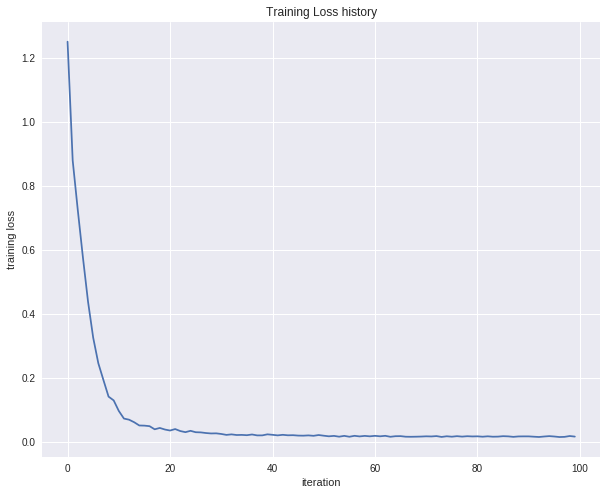

In [0]:
stats = net.train(X_train, y_train, X_train, y_train, 
                  learning_rate=1e-1, reg=5e-6,
                  num_iters=100, verbose=False)
print('Final training loss: ', stats['loss_history'][-1])

# plotarea costului
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# BONUS
# Incarcarea datasetului - CIFAR-10
Vom incarca datasetul folosindu-ne de **keras**. 

**Keras** este un wrapper peste **tensorflow** **(framework de deep learning)**. In laboaratoarele viitoare veti folosi tensorflow pentru a scrie retele. Tensorflow are scrise deja biblioteci de functii in C++ ce folosesc rutine optimizate pentru a rula cod cuda pe GPU. Pe acestea le veti apela direct din python. 

In laboratorul de astazi incercam sa implementam totul de mana direct in python pentru a intelege "magic"-ul din spatele Tensorflow-ului.

**CIFAR-10** este un dataset ce contine 50000 de imagini de train si 10000 imagini de test. Acestea eu dimensiuni 32x32x3. O sa spargem imaginile de train in doua splituri pentru a pastra 10000 de imagini pentru validare

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_val = X_train[40000:]
X_train = X_train[:40000]
y_val = y_train[40000:]
y_train = y_train[:40000]

Imaginile vor fi **vectorizate** inainte de a fi trimise retelei.

**Numarul de clase din CIFAR-10** este (big surprise here!) 10. 

### Preprocesarea datasetului
La acest pas, trebuie sa faceti o preprocesare minimala, normalizarea fiecarei imagini scazand valoarea medie peste tot datasetul. Imaginile sunt matrixi 32x32x3 cu tipul uint8, iar noi avem nevoie vectori de tip float32.


In [0]:
def preprocess_dataset(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train = X_train.reshape(y_train.shape[0], -1)
    X_test = X_test.reshape(y_test.shape[0], -1)
    X_val = X_val.reshape(y_val.shape[0], -1)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_val = X_val.astype('float32')
    y_train = y_train.reshape(y_train.shape[0])
    y_test = y_test.reshape(y_test.shape[0])
    y_val = y_val.reshape(y_val.shape[0])
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_test -= mean_image
    X_val -= mean_image
    return X_train, y_train, X_val, y_val, X_test, y_test

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_dataset(X_train, y_train, X_val, y_val, X_test, y_test)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Val data shape: ', X_val.shape)
print('Val labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (40000, 3072)
Train labels shape:  (40000,)
Val data shape:  (10000, 3072)
Val labels shape:  (10000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


## Antrenarea retelei pe CIFAR-10
Pentru a antrena reteaua folosim SGD. 

In [0]:
input_size = 32
input_channels = 3
input_dim = input_channels * input_size * input_size
hidden_dim = 50
num_classes = 10
net = ShallowNet(input_dim, hidden_dim, num_classes)
# Antrenam reteaua
stats = net.train(np.concatenate([X_train, X_test], 0), np.concatenate([y_train, y_test], 0), X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Facem preziceri pe datasetul de test si calculam acuratetea
test_acc = (net.predict(X_val) == y_val).mean()
print('Test accuracy: ', test_acc)



iteration 0 / 1000: loss 2.302927
iteration 100 / 1000: loss 2.302319
iteration 200 / 1000: loss 2.296649
iteration 300 / 1000: loss 2.256110
iteration 400 / 1000: loss 2.149004
iteration 500 / 1000: loss 2.106567
iteration 600 / 1000: loss 2.063197
iteration 700 / 1000: loss 2.060384
iteration 800 / 1000: loss 2.032255
iteration 900 / 1000: loss 1.962273
Test accuracy:  0.2863


# Debugging pentru procesul de antrenare
Test accuracy ar trebui sa fie cu parametrii de mai sus undeva la 0.28. Aceasta este o acuratete foarte mica, random ar fi undeva la 0.10, deci nu suntem foarte departe.
Pentru a vedea ce sa intampla cu antrenarea putem plota valorile erorii pentru antrenare si test

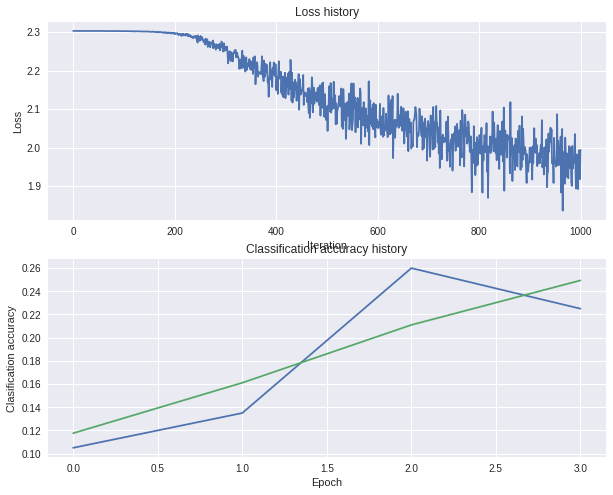

In [0]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

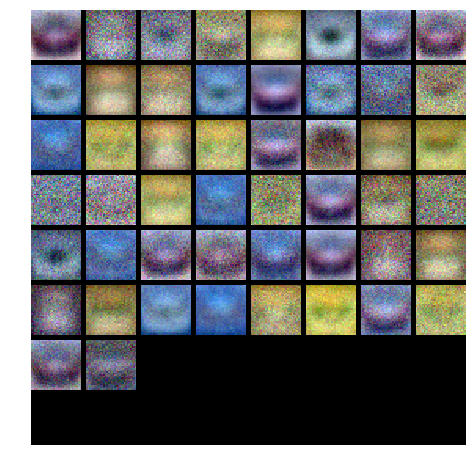

In [0]:
from utils import visualize_grid

# Vizualizarea parametrilor retelei

def show_net_weights(net, param_key):
    W1 = net.params[param_key]
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net, 'fc1_w')

# Tunarea hiperparametrilor
Cateva observatii:
* costul scade liniar ceea ce ar putea sugera ca putem mari rata de invatare
* nu exista niciun gap intre plotul accuratetii pe datale de invatare vs datele de test ceea ce ar putea sugera ca suntem in regimul de 'underfitting' si avem un model cu capacitate prea mica.
* pentru a dezvolta o intuitie de ce hiperparametrii merg in ce situatii, trebuie experimentat mult. Puteti experimenta cu diferite valori pentru urmatorii hiperparametrii: numarul de neuroni pe stratul ascuns (hidden_dim), rata de invatare etc. 
* in principiu ne dorim o acuratete pe datale de test > 48%.
* pentru a ajunge la o acuratete foarte mare, sunt foarte multe trick-uri pe care le vom invata in episoadele urmatoare.

In [0]:
best_net = net # cel mai bun model

#################################################################################
# TODO: Tunarea hiperparametrilor pe datele de validare.                        #
# Cel mai bun model trebuie stocat in best_net.                                 #
# Hint: Cea mai simpla tunare poate fi o iterare prin mai multe valori ale      #                            #
# parametrilor pentru hidden_dim, learning_rate, l2_reg, etc.  Departajarea     #
# celui mai bun model se poate face dupa acuratete                              #
#################################################################################
hidden_dims = [40, 60]
learning_rates = [1e-4, 5e-4]
l2_regs = [0.2]
best_acc = -1
log = {}
for hidden_dim in hidden_dims:
    for lr in learning_rates:
        for l2_reg in l2_regs:
            
            # Set up the network
            net = ShallowNet(input_dim, hidden_dim, num_classes)

            # Train the network
            stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters=1000, batch_size=200,
                        learning_rate=lr, learning_rate_decay=0.95,
                        reg=l2_reg, verbose=False)
            
            acc = stats['val_acc_history'][-1]
            log[(hidden_dim, lr, l2_reg)] = acc
            
            # Print Log
            print('Hidden_dim {} >> lr {} >> l2_reg {} >> val_acc {}'.format(hidden_dim, lr, l2_reg, acc))
            
            if acc > best_acc:
                best_net = net
                best_acc = acc
                
print('Best Network acc {}'.format(best_acc))
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

Hidden_dim 40 >> lr 0.0001 >> l2_reg 0.2 >> val_acc 0.2513
Hidden_dim 40 >> lr 0.0005 >> l2_reg 0.2 >> val_acc 0.4205
Hidden_dim 60 >> lr 0.0001 >> l2_reg 0.2 >> val_acc 0.2685
Hidden_dim 60 >> lr 0.0005 >> l2_reg 0.2 >> val_acc 0.4221
Best Network acc 0.4221


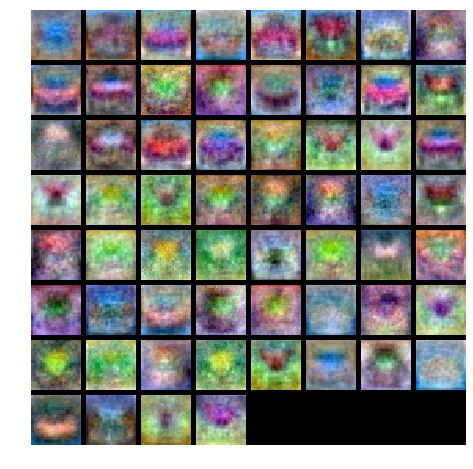

In [0]:
# visualize the weights of the best network
show_net_weights(best_net, 'fc1_w')

# Rularea pe datele de test 
Testul final al unei retele este rularea acesteia pe datele de test. De obiecei acestea sunt niste date pastrate deoparte pentru care nu avem label-urile/etichetele. De exemplu, in cadrul unei competitii, se vor publica datele de antrenare cu label-urile corespunzatoare acestora pentru antrenarea unui model, datele de validare cu label-urile corespunzatoare acestora pentru tunarea hiperparametrilor dupa antrenare, si datele de testare fara label-uri. Submisia in cardul unei competitii este facuta cu prezicerile modelului pentru datele de test.

In cazul de fata, noi vom fi si evaluatori, avand deja etichetele reale, putem sa ne calculam singuri acuratetea.

# New Section

In [0]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.4483
